In [1]:
#import libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
import glob
import requests
from itertools import repeat

In [2]:
#actual COVID-19 cases data for PA
url2 = 'https://raw.githubusercontent.com/IvanVoinovGitHub/Covid19-Analysis-Modeling/main/Data/COVID-19_Aggregate_Cases_Current_Daily_County_Health.csv'
df1 = pd.read_csv(url2)

In [3]:
url = 'https://github.com/reichlab/covid19-forecast-hub/tree/master/data-processed/UCLA-SuEIR'
download = requests.get(url).content

csvStringList = []
hrefStringList = []
urlExtension = []
rawUrls = []
tempList = []
urlExtensionwoutblob = []
urlBeginning = 'https://raw.githubusercontent.com'

urlStringList = str(requests.get(url).text).split(" ")
for i in urlStringList:
  if "csv" in i:
    csvStringList.append(i)

for i in csvStringList:
  if "href" in i and "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in i:
    hrefStringList.append(i)

for i in hrefStringList:
  tempList1 = i.split("\"")
  for x in tempList1:
    if "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in x:
      urlExtension.append(x)

for i in urlExtension:
  newString = ""
  tempList = []
  temp = i.split("/")
  for x in temp:
    if "blob" not in x:
      tempList.append(x)
  for j in range(1, len(tempList)):
    newString += "/" + tempList[j]
  urlExtensionwoutblob.append(newString)


for i in urlExtensionwoutblob:
  finalUrl = urlBeginning + i
  rawUrls.append(finalUrl)

In [4]:
#reading all the raw data, filtering PA cases data, and ensemble back into one dataframe
all_data = []
for url in rawUrls:
    df3=pd.read_csv(url)
    df2_case = df3[df3['target'].str.contains('case')]
    df2_casesPA = df2_case[(df2_case["type"]=="point") & (df2_case["location"]=="42")]
    all_data.append(df2_casesPA)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
len(all_data)

65

In [6]:
df2 = pd.concat(all_data)
df2.head(5)

,location,target,type,quantile,forecast_date,target_end_date,value
32376,42,1 wk ahead inc case,point,NaN,2020-07-05,2020-07-11,4606.081808
32377,42,2 wk ahead inc case,point,NaN,2020-07-05,2020-07-18,5527.067721
32378,42,3 wk ahead inc case,point,NaN,2020-07-05,2020-07-25,5988.104715
32379,42,4 wk ahead inc case,point,NaN,2020-07-05,2020-08-01,6208.918747
32380,42,5 wk ahead inc case,point,NaN,2020-07-05,2020-08-08,6233.005493


In [7]:
#convert date to datetime object
df1['Date'] = pd.to_datetime(df1['Date'])
df2['forecast_date'] = pd.to_datetime(df2['forecast_date'])
df2['target_end_date'] = pd.to_datetime(df2['target_end_date'])

In [8]:
#sort datasets by date
df1.sort_values(by='Date')
df2.sort_values(by='target_end_date')

,location,target,type,quantile,forecast_date,target_end_date,value
32376,42,1 wk ahead inc case,point,NaN,2020-07-05,2020-07-11,4606.081808
32377,42,2 wk ahead inc case,point,NaN,2020-07-05,2020-07-18,5527.067721
31640,42,1 wk ahead inc case,point,NaN,2020-07-12,2020-07-18,5893.812597
32378,42,3 wk ahead inc case,point,NaN,2020-07-05,2020-07-25,5988.104715
31640,42,1 wk ahead inc case,point,NaN,2020-07-19,2020-07-25,5628.681386
...,...,...,...,...,...,...,...
30174,42,7 wk ahead inc case,point,NaN,2022-03-06,2022-04-23,6470.621979
30175,42,8 wk ahead inc case,point,NaN,2022-02-27,2022-04-23,5305.099736
30174,42,7 wk ahead inc case,point,NaN,2022-03-13,2022-04-30,6611.861705
30175,42,8 wk ahead inc case,point,NaN,2022-03-06,2022-04-30,5592.610815


In [9]:
#filterinng out data for PA (FIPS code = 42)
df2_2 = df2[df2['target'].str.contains('1')]
df2_2.shape

(56, 7)

In [10]:
#finding weekly increase in cases in PA
df_weekly=df2_2.groupby('target_end_date').agg('last').reset_index()
df_weekly.rename(
    columns={"target_end_date":"Date"},inplace=True)
#df_weekly

In [11]:
#creating a column for daily additions
df_weekly["dayRate"] = df_weekly["value"] / 7
mask = (df_weekly['Date'] <= '2021-03-01')
df_weekly = df_weekly.loc[mask]
df_weekly.head(5)

,Date,location,target,type,quantile,forecast_date,value,dayRate
0,2020-07-11,42,1 wk ahead inc case,point,NaN,2020-07-05,4606.081808,658.011687
1,2020-07-18,42,1 wk ahead inc case,point,NaN,2020-07-12,5893.812597,841.973228
2,2020-07-25,42,1 wk ahead inc case,point,NaN,2020-07-19,5628.681386,804.097341
3,2020-08-01,42,1 wk ahead inc case,point,NaN,2020-07-26,7523.673555,1074.810508
4,2020-08-08,42,1 wk ahead inc case,point,NaN,2020-08-02,7176.734730,1025.247819


In [12]:
df_weekly.tail(5)

,Date,location,target,type,quantile,forecast_date,value,dayRate
28,2021-01-23,42,1 wk ahead inc case,point,NaN,2021-01-17,38587.259032,5512.465576
29,2021-01-30,42,1 wk ahead inc case,point,NaN,2021-01-24,37639.195456,5377.027922
30,2021-02-06,42,1 wk ahead inc case,point,NaN,2021-01-31,39885.466805,5697.923829
31,2021-02-13,42,1 wk ahead inc case,point,NaN,2021-02-07,26699.971402,3814.281629
32,2021-02-27,42,1 wk ahead inc case,point,NaN,2021-02-21,19551.421724,2793.060246


In [13]:
# creating a list of predictions from the model data
predictions = []
for i in df_weekly["dayRate"]:
    predictions.extend(repeat(i,7))
#del predictions[-2:]
#preds = pd.DataFrame(predictions)
#preds.drop(preds.tail(2).index,inplace=True) 
print(predictions)

[658.0116869152449, 658.0116869152449, 658.0116869152449, 658.0116869152449, 658.0116869152449, 658.0116869152449, 658.0116869152449, 841.9732281002216, 841.9732281002216, 841.9732281002216, 841.9732281002216, 841.9732281002216, 841.9732281002216, 841.9732281002216, 804.0973408033294, 804.0973408033294, 804.0973408033294, 804.0973408033294, 804.0973408033294, 804.0973408033294, 804.0973408033294, 1074.810507873703, 1074.810507873703, 1074.810507873703, 1074.810507873703, 1074.810507873703, 1074.810507873703, 1074.810507873703, 1025.247818521357, 1025.247818521357, 1025.247818521357, 1025.247818521357, 1025.247818521357, 1025.247818521357, 1025.247818521357, 786.6020863939588, 786.6020863939588, 786.6020863939588, 786.6020863939588, 786.6020863939588, 786.6020863939588, 786.6020863939588, 901.1451125264783, 901.1451125264783, 901.1451125264783, 901.1451125264783, 901.1451125264783, 901.1451125264783, 901.1451125264783, 638.2385300756889, 638.2385300756889, 638.2385300756889, 638.2385300

In [14]:
len(predictions)

231

In [15]:
#select all the dates to be merged with prediction list
mask = (df1['Date'] >= '2020-07-11') & (df1['Date'] <= '2021-02-26')
df1_copy = df1.loc[mask]
df1_copy = df1_copy.groupby(["Date"]).sum().reset_index()
df1_copy.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
0,2020-07-11,1320,1533.8,198586,25603978,225.5,252.8,28684.6,2860489,-5275.682283,2774.207671
1,2020-07-12,806,1501.4,199392,25603978,178.6,259.3,28863.7,2860489,-5275.682283,2774.207671
2,2020-07-13,1828,1533.2,201220,25603978,303.9,265.9,29167.7,2860489,-5275.682283,2774.207671
3,2020-07-14,1976,1558.5,203196,25603978,358.0,272.8,29525.8,2860489,-5275.682283,2774.207671
4,2020-07-15,1660,1582.0,204856,25603978,261.2,277.8,29787.0,2860489,-5275.682283,2774.207671


In [51]:
df1_copy.tail(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude,Prediction,Error,Accuracy,RawError
226,2021-02-22,5812,5363.5,1851728,25603978,1500.7,1335.4,504867.8,2860489,-5275.682283,2774.207671,2793.060246,0.519432,0.480568,-0.519432
227,2021-02-23,5536,5151.1,1857264,25603978,1377.7,1287.6,506245.3,2860489,-5275.682283,2774.207671,2793.060246,0.495473,0.504527,-0.495473
228,2021-02-24,4918,4911.6,1862182,25603978,1242.2,1262.9,507487.2,2860489,-5275.682283,2774.207671,2793.060246,0.432074,0.567926,-0.432074
229,2021-02-25,6836,5089.5,1869018,25603978,1946.2,1316.2,509433.7,2860489,-5275.682283,2774.207671,2793.060246,0.591419,0.408581,-0.591419
230,2021-02-26,6994,5277.5,1876012,25603978,1670.7,1334.7,511103.9,2860489,-5275.682283,2774.207671,2793.060246,0.600649,0.399351,-0.600649


In [16]:
len(df1_copy)

231

In [17]:
# assigning predictions list to the actual dataframe
df1_copy['Prediction'] = predictions

In [ ]:
df1_copy.head(20)

In [19]:
# renaming the dataframe for graphing
merged_df_new = df1_copy

In [20]:
merged_df_new.shape

(231, 12)

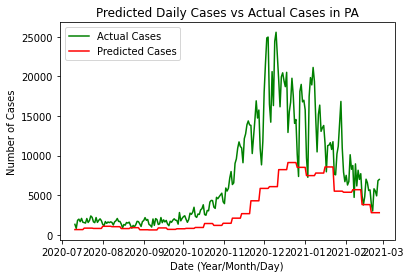

In [21]:
#Create plot of Actual vs. Predicted Cases

#Actual Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['New Cases'], color='g', label='Actual Cases')

#Predicted Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['Prediction'], color='r', label='Predicted Cases')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Number of Cases') 
plt.title("Predicted Daily Cases vs Actual Cases in PA")

#Display Plot
plt.legend()
plt.show()

In [22]:
#error calculations
#confirmed = merged_df_new['Actual']
#projected = merged_df_new['Prediction']
error = []
rawerror = []

for index, row in merged_df_new.iterrows():
  rawerror.append(-1*(row['New Cases'] - row["Prediction"]) / row['New Cases'])
  error.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

underpredictCount = 0
overpredictCount = 0
for x in rawerror:
  if x < 0:
    underpredictCount += 1
  elif x > 0:
    overpredictCount += 1

underpredictPerecentage = underpredictCount / len(rawerror)
overpredictPercentage = 1 - underpredictPerecentage

print(underpredictCount)
print(underpredictPerecentage)
print(overpredictCount)
print(overpredictPercentage)
print(len(error))

print(error)
print(rawerror)

225
0.974025974025974
6
0.025974025974025983
231
[0.5015062977914811, 0.18360832888927428, 0.6400373703964743, 0.666998134152204, 0.6036074175209368, 0.682426792029322, 0.5840634090295544, 0.45468055174856115, 0.43109917020255295, 0.5908779260931868, 0.45888610019265963, 0.5327562552163032, 0.646526772418043, 0.6183258258838524, 0.5084979579441752, 0.47649912708116576, 0.6311480088058122, 0.48783608866029976, 0.5596400105129631, 0.6007461068503827, 0.5497775247461761, 0.18574961524719466, 0.06862174361030932, 0.3579387647110496, 0.2567008935866507, 0.3365367235347512, 0.2984265614401416, 0.3446277391014006, 0.3411003737009274, 0.17185151977273266, 0.3733204043267989, 0.42207000083350793, 0.5023068842129335, 0.39262569992810603, 0.39477696663438194, 0.4249984748582173, 0.1081608997800921, 0.3967775411089273, 0.3562994383028161, 0.4931687587667791, 0.4670717571856648, 0.5083736960037758, 0.24904573956126805, 0.06267112326235652, 0.24146034299117985, 0.11304614908811188, 0.294878628696026

In [23]:
#accuracy calculations
accuracy = []

for i in error:
  accuracy.append(1 - i)

print(accuracy)

[0.49849370220851885, 0.8163916711107257, 0.35996262960352565, 0.333001865847796, 0.39639258247906317, 0.317573207970678, 0.41593659097044555, 0.5453194482514389, 0.568900829797447, 0.4091220739068132, 0.5411138998073404, 0.4672437447836968, 0.353473227581957, 0.38167417411614757, 0.4915020420558248, 0.5235008729188342, 0.36885199119418777, 0.5121639113397003, 0.4403599894870369, 0.39925389314961734, 0.45022247525382386, 0.8142503847528053, 0.9313782563896906, 0.6420612352889504, 0.7432991064133493, 0.6634632764652488, 0.7015734385598584, 0.6553722608985995, 0.6588996262990726, 0.8281484802272674, 0.6266795956732011, 0.5779299991664921, 0.49769311578706654, 0.607374300071894, 0.6052230333656181, 0.5750015251417827, 0.8918391002199079, 0.6032224588910726, 0.6437005616971839, 0.5068312412332209, 0.5329282428143352, 0.4916263039962242, 0.7509542604387319, 0.9373288767376435, 0.7585396570088201, 0.8869538509118882, 0.7051213713039737, 0.529462463294053, 0.5415535532010086, 0.46249168846064

In [ ]:
#Create Error and Accuracy Column and insert list data
merged_df_new['Error'] = error
merged_df_new['Accuracy'] = accuracy
merged_df_new['RawError'] = rawerror

print(merged_df_new)

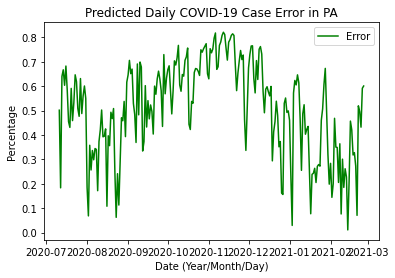

In [25]:
from IPython.core.pylabtools import figsize
#Create plot of Error

#Error Line
plt.plot(merged_df_new['Date'], merged_df_new['Error'], color='g', label='Error')


#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Error in PA")
#Display Plot
plt.legend()

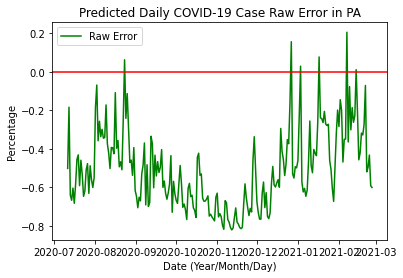

In [26]:
#Create plot of Raw Error

#Raw Error Line
plt.plot(merged_df_new['Date'], merged_df_new['RawError'], color='g', label='Raw Error')
plt.axhline(y=0.0, color='r', linestyle='-')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Raw Error in PA")
#Display Plot
plt.legend()
plt.show()

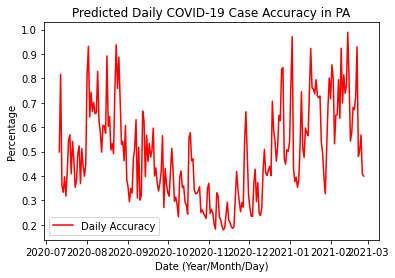

In [27]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [28]:
#Calculate Weekly Accuracy Averages
weeklyAccuracy = 0
averageWeeklyAccuracy = []
length = len(accuracy) #   =245
amountOfWeeks = int(length / 7) #   =35
remainderDays = length % 7 #  

i = 0
while i < length:
  weeklyAccuracy += accuracy[i]
  if (i + 1) % 7 == 0 and amountOfWeeks > 0:
    averageWeeklyAccuracy.append(weeklyAccuracy / 7)
    amountOfWeeks -= 1
    weeklyAccuracy = 0
  if remainderDays > 0:
    if (i + 1) % remainderDays == 0 and amountOfWeeks == 0:
      averageWeeklyAccuracy.append(weeklyAccuracy / remainderDays)
      weeklyAccuracy = 0
  i += 1

weeklyDateList = []
i = 0
weeklyDateList.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 7 == 0:
    weeklyDateList.append(merged_df_new['Date'][i])
  i += 1

In [29]:
len(weeklyDateList)

34

In [30]:
#del averageWeeklyAccuracy[-1:]
#len(averageWeeklyAccuracy)

In [31]:
#Create Dataframe for Weekly Accuracy
i = 0
data = []
while i < len(averageWeeklyAccuracy):
  data.append([weeklyDateList[i], averageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Week Of', 'Average Weekly Accuracy'])

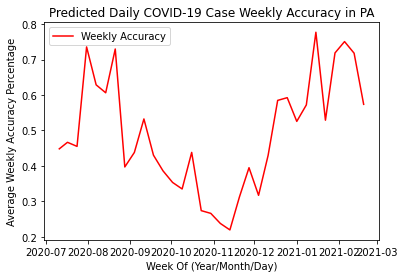

In [32]:
#Create plot of Weekly Accuracy

#Accuracy Line
plt.plot(df['Week Of'], df['Average Weekly Accuracy'], color='r', label='Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Week Of (Year/Month/Day)') 
plt.ylabel('Average Weekly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [33]:
#Create Running Weekly Average
runningweeklyAccuracy = 0
runningAverageWeeklyAccuracy = []
length = len(accuracy)

i = 1
j = 8
#Add first week average
runningAverageWeeklyAccuracy.append(averageWeeklyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningweeklyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageWeeklyAccuracy.append(runningweeklyAccuracy / 7)
  runningweeklyAccuracy = 0

  i += 1
  j += 1

In [34]:
#Create Dataframe for Running Weekly Accuracy
i = 0
data = []
while i < len(runningAverageWeeklyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Weekly Average Accuracy'])

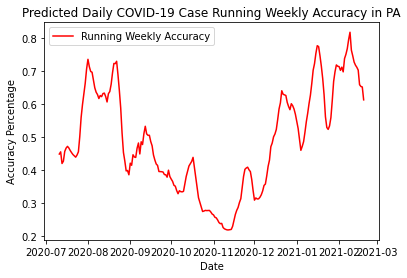

In [35]:
#Create plot of Running Weekly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='r', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

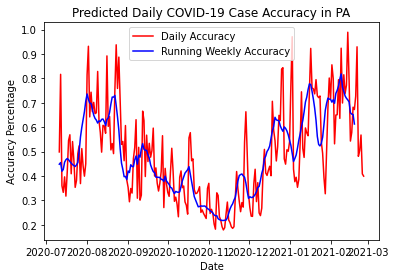

In [36]:
#Plot with combined daily accuracy and running weekly accuracy

#Daily Accuracy
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Running Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='b', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [37]:
#merged_df_new.to_csv('DDS_everyday_predictions.csv')

In [38]:
#Calculate Monthly Accuracy Averages
#We are going to use an average of 30 days per month for these calculations

monthlyAccuracy = 0
averageMonthlyAccuracy = []
amountOfMonths = int(length / 30)
remainderDays = length % 30

i = 0
while i < length:
  monthlyAccuracy += accuracy[i]
  if (i + 1) % 30 == 0 and amountOfMonths > 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / 30)
    amountOfMonths -= 1
    monthlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfMonths == 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / remainderDays)
    monthlyAccuracy = 0
  i += 1

weeklyDateListForMonths = []
i = 0
weeklyDateListForMonths.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 30 == 0:
    weeklyDateListForMonths.append(merged_df_new['Date'][i])
  i += 1


In [39]:
del averageMonthlyAccuracy[-1:]
len(averageMonthlyAccuracy)

8

In [40]:
#Create Dataframe for Monthly Accuracy
i = 0
data = []
while i < len(averageMonthlyAccuracy):
  data.append([weeklyDateListForMonths[i], averageMonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Month Of', 'Average Monthly Accuracy'])

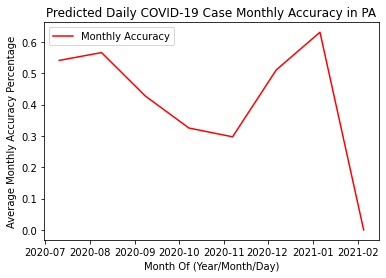

In [41]:
#Create plot of Monthly Accuracy

#Accuracy Line
plt.plot(df['Month Of'], df['Average Monthly Accuracy'], color='r', label='Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Month Of (Year/Month/Day)') 
plt.ylabel('Average Monthly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [42]:
#Calculate Running Monthly Accuracy

runningmonthlyAccuracy = 0
runningAveragemonthlyAccuracy = []
length = len(accuracy)

i = 1
j = 31
#Add first week average
runningAveragemonthlyAccuracy.append(averageMonthlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningmonthlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAveragemonthlyAccuracy.append(runningmonthlyAccuracy / 30)
  runningmonthlyAccuracy = 0

  i += 1
  j += 1

In [43]:
#Create Dataframe for Running Monthly Accuracy
i = 0
data = []
while i < len(runningAveragemonthlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAveragemonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Monthly Average Accuracy'])

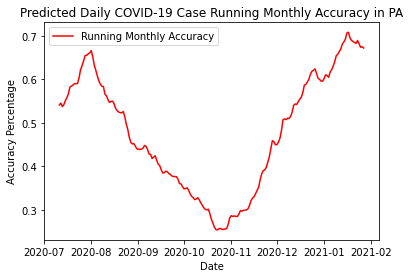

In [44]:
#Create plot of Running Monthly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Monthly Average Accuracy'], color='r', label='Running Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [47]:
#Calculate Overall Accuracy
overallAccuracy = merged_df_new['Accuracy'].mean()
print(overallAccuracy)

0.49021886572568163


In [48]:
#cleans accuracy list of all nan values
newlist = [x for x in accuracy if math.isnan(x) == False]
print(newlist)

[0.49849370220851885, 0.8163916711107257, 0.35996262960352565, 0.333001865847796, 0.39639258247906317, 0.317573207970678, 0.41593659097044555, 0.5453194482514389, 0.568900829797447, 0.4091220739068132, 0.5411138998073404, 0.4672437447836968, 0.353473227581957, 0.38167417411614757, 0.4915020420558248, 0.5235008729188342, 0.36885199119418777, 0.5121639113397003, 0.4403599894870369, 0.39925389314961734, 0.45022247525382386, 0.8142503847528053, 0.9313782563896906, 0.6420612352889504, 0.7432991064133493, 0.6634632764652488, 0.7015734385598584, 0.6553722608985995, 0.6588996262990726, 0.8281484802272674, 0.6266795956732011, 0.5779299991664921, 0.49769311578706654, 0.607374300071894, 0.6052230333656181, 0.5750015251417827, 0.8918391002199079, 0.6032224588910726, 0.6437005616971839, 0.5068312412332209, 0.5329282428143352, 0.4916263039962242, 0.7509542604387319, 0.9373288767376435, 0.7585396570088201, 0.8869538509118882, 0.7051213713039737, 0.529462463294053, 0.5415535532010086, 0.46249168846064

In [49]:
#calculate variance and st deviation of accuracy
var = sum((l-overallAccuracy)**2 for l in newlist) / len(newlist)
st_dev = math.sqrt(var)
print(var)
print(st_dev)

0.036708461580496295
0.1915945238791973


In [50]:
#calculate median of accuracy
accMedian = statistics.median(newlist)
print(accMedian)

0.4700456684678007


In [53]:
#Seperate Running Weekly Average plot into 3 plots for the 3 variants: Original, Delta, Omicron

# Start Date - May 20th 2021

In [52]:
type(merged_df_new['Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [54]:
merged_df_new.index[merged_df_new['Date']=='2021-02-26'].tolist()

[230]

In [55]:
#print(merged_inner)
standardVariantDF = merged_df_new[:230]

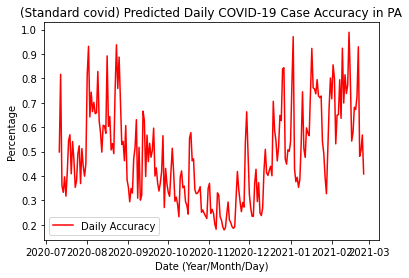

In [56]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(standardVariantDF['Date'], standardVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Standard covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()